In [2]:
# The torch package offers multi-dimensional tensor data structures as well as mathematical operations on these tensors. 
# It also includes a number of tools for efficient serialisation of Tensors and arbitrary types, 
# as well as other helpful features.

!pip install torch

In [8]:
# Torchvision is a Computer Vision library that works in tandem with PyTorch. 
# It includes tools for doing efficient image and video transformations, as well as pre-trained models and datasets 
# Torchvision is not included with PyTorch and must be installed independently.

!pip install torchvision

  Using cached torchvision-0.10.1-cp38-cp38-win_amd64.whl (936 kB)


In [4]:
# Pandas is a python library that allows to work with large data collections.
# It offers tools for data analysis, cleansing, exploration, and manipulation.

!pip install pandas

In [5]:
# tqdm is a Python module that allows to create Progress Meters or Progress Bars.
# It displays the Code Execution Time and the Estimated Time for the code to finish, 
# which is useful when working with large datasets.

!pip install tqdm

In [6]:
# NumPy is a Python module that allows you to interact with arrays.
# It also provides functions for working with matrices, fourier transforms, and linear algebra.

!pip install numpy

In [1]:
# Importing basic libraries and classes  in torch and torchvision

import os
import torch
import torchvision
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.datasets.folder import default_loader
from torchvision.utils import save_image
from tqdm.notebook import tqdm


In [2]:
# Defining batch size, image size, mean and standard deviation

batch_dimension = 128
image_dimension = (64,64)
statistics = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [3]:
# Facial image data is downloaded from open source, then stored and read from the local drive path
# All the images are resized and cropped to 64*64 pixels
# The pixel values are normalised with a mean and standard deviation of 0.5 for each channel
# This helps the pixel values to be within the acceptable range of (-1, 1), 
# pixel values will be symmetrically distributed around 0 rather than being in a range of 0 to 1

IMAGE_DATA_PATH = r"C:\Users\deepa\Documents\LYIT\img_align_celeba-20210624T211827Z-001\img_align_celeba"

transform_data_structure = transforms.Compose([transforms.Resize(image_dimension),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*statistics)
                                   ])

train_data_structure = torchvision.datasets.ImageFolder(root = IMAGE_DATA_PATH,
                                     transform = transform_data_structure)

# A training data loader is created to load the data in defined batch sizes. 
# It will take unique order of training dataset in each epoch having a batch size of 128. 
# The images will be picked in a shuffled way, so that the randomisation helps training and generalise the model faster. 
# Num_workers = 3 and pin_memory = true option ensures that multiple cores are used from the machine to read the images.

train_dataset_random = torch.utils.data.Subset(train_data_structure, 
                                               np.random.choice(len(train_data_structure), 25000, replace = False))
train_dataloader = DataLoader(train_dataset_random, batch_dimension, shuffle = True, num_workers = 3, pin_memory = True)

In [4]:
# Developing helper functions to de-normalise the image tensor and display some sample images from the training batch. 
# Here torchvision utility function “make_grid” and matplotlib function “pyplot“ is used for plotting

# De-normalization function: It takes the image tensors multiplied by the standard deviation of 0.5 and then adding the means. 
# This will deformalize the images, by bringing it back to range of (0, -1). 
def denormalization(image_tensors):
    return image_tensors * statistics[1][0] + statistics[0][0]


# Show images function: It takes up to maximum number of 64 image tensors, and plots them in grid. 
def display_images(images, nmax = 64):
    fig, ax = plt.subplots(figsize = (8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denormalization(images.detach()[:nmax]), nrow = 8).permute(1, 2, 0))

    
# Show batch function:  It takes up to maximum number of 64 images from dataloader and displays them.     
def display_batch(dl, nmax = 64):
    for images, _ in dl:
        display_images(images, nmax)
        break

        
# Function to check if the hardware GPU is available or not. If GPU is not available then use CPU.        
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
    
device = get_default_device()
train_dataloader = DeviceDataLoader(train_dataloader, device)



In [5]:
# GAN Discriminator Model Building
# nn.sequential class is used where a set of layers is passed having kernel size of 4 and stride of 2. 
# The first convolutional layer is start with an input image of 64 X 64 into 3 input channels 
# and 64 output channels resulting image of half 32 X 32. 
# Leaky ReLU activation for the discriminator allows the pass of a small gradient signal for negative values.
# Once the image is flattened into a 1 *1 vector, the Sigmoid function is implemented. 
# Finally, model is moved to the device by using the to_device function which will move all the weights to the GPU or CPU.

discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace = True),
    # output dimension: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace = True),
    # output dimension: 128 x 16 x 16
    
    nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace = True),
    # output dimension: 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace = True),
    # output dimension: 512 x 4 x 4
    
    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
    # output dimension: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid())

discriminator = to_device(discriminator, device)

In [6]:
# GAN Generator Model Building
# The initial latent_size will be defined as 150.
# nn.sequential class is used where a set of layers is passed having kernel size of 4 and stride of 2. 
# The normal ReLU activation and TanH activation function is implemented for generator

latent_dimension = 150

generator = nn.Sequential(
    nn.ConvTranspose2d(latent_dimension, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # output dimension: 514 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # output dimension: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # output dimension: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # output dimension: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()
    # output dimension: 3 x 64 x 64
)

generator = to_device(generator, device)


In [7]:
#rand_latent_tensors = torch.randn(batch_dimension, latent_dimension, 1, 1) # random latent tensors
rand_latent_tensors = torch.randn(128, 150, 1, 1) # random latent tensors


fake_images = generator(rand_latent_tensors)
print(fake_images.shape)


torch.Size([128, 3, 64, 64])


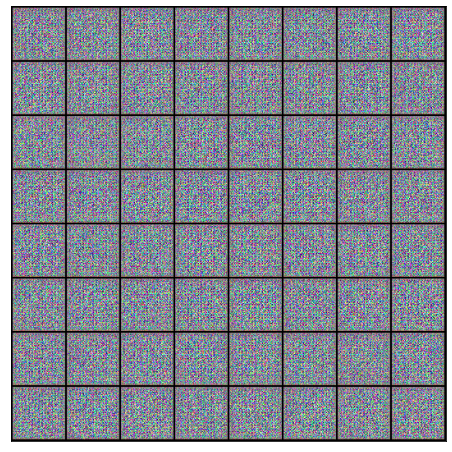

In [8]:
# The very first image grid is displayed 

display_images(fake_images, nmax = 64)
#display_batches(fake_images)

In [9]:
# GAN Model Training

# The discriminator model definition is passed a set of real images and a optimiser. 
# Clear all the gradients before passing the real images to the discriminator and then real predictions is achieved.
# The binary cross entropy loss function is used to assess how well the discriminator can distinguish between actual and produced pictures 
# because it is a binary classification model

def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device = device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    latent = torch.randn(batch_dimension, latent_dimension, 1, 1, device = device)
    fake_images = generator(latent)
    fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

# Similar to discriminator model, generator model is also trained. 
# First the model is assessed with an optimiser after clearing all the gradients. 
# Then a batch of latent tensor is created using random function from torch.
# Further this latent tensor is passed to the generator model to produce fake images. 
# Loss.backward calculate the derivatives of the gradient of the loss with respect to the parameters of the generators weights in bias.

def train_generator(opt_g):
    opt_g.zero_grad()
    latent = torch.randn(batch_dimension, latent_dimension, 1, 1, device = device)
    fake_images = generator(latent)
    preds = discriminator(fake_images)
    targets = torch.ones(batch_dimension, 1, device = device)
    loss = F.binary_cross_entropy(preds, targets)
    loss.backward()
    opt_g.step()
    return loss.item()

In [10]:
# Directories created to save the generated images 
# Parent Directories
parent_dir = r"C:\Users\deepa\Documents\LYIT"
sample_dir = '\generated2'

# Path
sample_dir = os.path.join(parent_dir, sample_dir)
 
# Create the directory
# 'generated'
os.makedirs(sample_dir, exist_ok = True)
print("Directory '%s' created" %sample_dir)



Directory 'C:\generated2' created


In [11]:
# The intermediate images are saved after completion of each epoch.  

def save_samples(index, latent_tensors, show = True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
        
    save_image(denormalization(fake_images), os.path.join(sample_dir, fake_fname), nrow = 8)
    
    
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize = (8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 8).permute(1, 2, 0))

fixed_latent = torch.randn(64, latent_dimension, 1, 1, device = device)

In [12]:
# Real score is an evaluation metrics where average prediction that is made by the discriminator for the batch of real images. 
# And fake score is an another evaluation metrics where mean of the fake images prediction is calculated.

def fit(epochs, lr, start_idx = 1):
    torch.cuda.empty_cache()
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999))
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dataloader):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)
            
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch + 1, epochs, loss_g, loss_d, real_score, fake_score))
        
        save_samples(epoch+start_idx, fixed_latent, show = False)
      
    return losses_g, losses_d, real_scores, fake_scores



In [16]:
# Learning Rate defined as 0.001 and total number of epochs as 500
# the checkpoint files contains the metagraph, 
# i.e. the structure of your computation graph, 
# without the values of the variables (basically what you can see in tensorboard/graph).

lr = 0.001
epochs = 500

# Fake images generated and saved after each epoch in the local folder /generated2.  
history = fit(epochs, lr)
losses_g, losses_d, real_scores, fake_scores = history
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')


Epoch [1/500], loss_g: 1.8274, loss_d: 1.7872, real_score: 0.2460, fake_score: 0.0220
Saving generated-images-0001.png



Epoch [2/500], loss_g: 2.9905, loss_d: 0.8476, real_score: 0.6525, fake_score: 0.2576
Saving generated-images-0002.png



Epoch [3/500], loss_g: 2.1425, loss_d: 0.8092, real_score: 0.6511, fake_score: 0.2245
Saving generated-images-0003.png



Epoch [4/500], loss_g: 1.6930, loss_d: 0.9139, real_score: 0.5463, fake_score: 0.1704
Saving generated-images-0004.png



Epoch [5/500], loss_g: 3.9764, loss_d: 0.7949, real_score: 0.8669, fake_score: 0.4225
Saving generated-images-0005.png



Epoch [6/500], loss_g: 1.7837, loss_d: 0.7071, real_score: 0.6836, fake_score: 0.2060
Saving generated-images-0006.png



Epoch [7/500], loss_g: 0.1951, loss_d: 2.4587, real_score: 0.1386, fake_score: 0.0178
Saving generated-images-0007.png



Epoch [8/500], loss_g: 2.2373, loss_d: 0.7768, real_score: 0.5957, fake_score: 0.1171
Saving generated-images-0008.png



Epoch [9/500], loss_g: 4.7114, loss_d: 0.7859, real_score: 0.9184, fake_score: 0.4423
Saving generated-images-0009.png



Epoch [10/500], loss_g: 3.3710, loss_d: 0.3490, real_score: 0.8679, fake_score: 0.1626
Saving generated-images-0010.png



Epoch [11/500], loss_g: 3.1704, loss_d: 0.5498, real_score: 0.9288, fake_score: 0.3300
Saving generated-images-0011.png



Epoch [12/500], loss_g: 0.8024, loss_d: 0.7302, real_score: 0.6038, fake_score: 0.1131
Saving generated-images-0012.png



Epoch [13/500], loss_g: 2.4645, loss_d: 0.3436, real_score: 0.8088, fake_score: 0.1037
Saving generated-images-0013.png



Epoch [14/500], loss_g: 3.5755, loss_d: 0.4769, real_score: 0.9457, fake_score: 0.3069
Saving generated-images-0014.png



Epoch [15/500], loss_g: 1.9239, loss_d: 0.7332, real_score: 0.6212, fake_score: 0.0580
Saving generated-images-0015.png



Epoch [16/500], loss_g: 3.1300, loss_d: 0.9432, real_score: 0.6803, fake_score: 0.2754
Saving generated-images-0016.png



Epoch [17/500], loss_g: 2.0758, loss_d: 0.5477, real_score: 0.6842, fake_score: 0.0503
Saving generated-images-0017.png



Epoch [18/500], loss_g: 2.2078, loss_d: 0.5008, real_score: 0.7249, fake_score: 0.1099
Saving generated-images-0018.png



Epoch [19/500], loss_g: 3.4172, loss_d: 0.4136, real_score: 0.8892, fake_score: 0.2130
Saving generated-images-0019.png



Epoch [20/500], loss_g: 2.5525, loss_d: 0.3987, real_score: 0.7419, fake_score: 0.0426
Saving generated-images-0020.png



Epoch [21/500], loss_g: 4.4509, loss_d: 0.2972, real_score: 0.9704, fake_score: 0.2008
Saving generated-images-0021.png



Epoch [22/500], loss_g: 2.9733, loss_d: 0.3157, real_score: 0.8516, fake_score: 0.1160
Saving generated-images-0022.png



Epoch [23/500], loss_g: 2.6267, loss_d: 0.5149, real_score: 0.6551, fake_score: 0.0134
Saving generated-images-0023.png



Epoch [24/500], loss_g: 0.7368, loss_d: 1.0093, real_score: 0.4469, fake_score: 0.0146
Saving generated-images-0024.png



Epoch [25/500], loss_g: 2.4728, loss_d: 0.3274, real_score: 0.8328, fake_score: 0.0998
Saving generated-images-0025.png



Epoch [26/500], loss_g: 1.4189, loss_d: 1.1480, real_score: 0.4934, fake_score: 0.0561
Saving generated-images-0026.png



Epoch [27/500], loss_g: 0.9167, loss_d: 0.9636, real_score: 0.4863, fake_score: 0.0225
Saving generated-images-0027.png



Epoch [28/500], loss_g: 6.0013, loss_d: 1.0354, real_score: 0.9923, fake_score: 0.5237
Saving generated-images-0028.png



Epoch [29/500], loss_g: 2.5242, loss_d: 0.5092, real_score: 0.7273, fake_score: 0.0978
Saving generated-images-0029.png



Epoch [30/500], loss_g: 3.9256, loss_d: 0.2525, real_score: 0.9386, fake_score: 0.1474
Saving generated-images-0030.png



Epoch [31/500], loss_g: 3.1068, loss_d: 0.2079, real_score: 0.8788, fake_score: 0.0562
Saving generated-images-0031.png



Epoch [32/500], loss_g: 2.4748, loss_d: 0.5640, real_score: 0.7671, fake_score: 0.1669
Saving generated-images-0032.png



Epoch [33/500], loss_g: 2.8636, loss_d: 0.2422, real_score: 0.8648, fake_score: 0.0717
Saving generated-images-0033.png



Epoch [34/500], loss_g: 7.8742, loss_d: 3.7763, real_score: 0.9985, fake_score: 0.9172
Saving generated-images-0034.png



Epoch [35/500], loss_g: 2.2333, loss_d: 0.4263, real_score: 0.8037, fake_score: 0.1205
Saving generated-images-0035.png



Epoch [36/500], loss_g: 1.8959, loss_d: 1.1539, real_score: 0.5076, fake_score: 0.0820
Saving generated-images-0036.png



Epoch [37/500], loss_g: 5.6830, loss_d: 0.8390, real_score: 0.9873, fake_score: 0.4658
Saving generated-images-0037.png



Epoch [38/500], loss_g: 4.0985, loss_d: 0.1375, real_score: 0.8988, fake_score: 0.0209
Saving generated-images-0038.png



Epoch [39/500], loss_g: 3.2263, loss_d: 1.1180, real_score: 0.7024, fake_score: 0.3581
Saving generated-images-0039.png



Epoch [40/500], loss_g: 1.2778, loss_d: 0.3673, real_score: 0.7472, fake_score: 0.0235
Saving generated-images-0040.png



Epoch [41/500], loss_g: 4.6914, loss_d: 0.1099, real_score: 0.9797, fake_score: 0.0747
Saving generated-images-0041.png



Epoch [42/500], loss_g: 3.3377, loss_d: 0.2740, real_score: 0.9006, fake_score: 0.1276
Saving generated-images-0042.png



Epoch [43/500], loss_g: 1.6306, loss_d: 0.7909, real_score: 0.5700, fake_score: 0.0108
Saving generated-images-0043.png



Epoch [44/500], loss_g: 4.6048, loss_d: 0.3678, real_score: 0.9211, fake_score: 0.1975
Saving generated-images-0044.png



Epoch [45/500], loss_g: 5.5233, loss_d: 0.6938, real_score: 0.9907, fake_score: 0.3785
Saving generated-images-0045.png



Epoch [46/500], loss_g: 3.9176, loss_d: 0.1674, real_score: 0.9289, fake_score: 0.0729
Saving generated-images-0046.png



Epoch [47/500], loss_g: 5.1862, loss_d: 0.8124, real_score: 0.9028, fake_score: 0.3654
Saving generated-images-0047.png



Epoch [48/500], loss_g: 3.8057, loss_d: 0.0953, real_score: 0.9582, fake_score: 0.0475
Saving generated-images-0048.png



Epoch [49/500], loss_g: 7.0144, loss_d: 0.1058, real_score: 0.9150, fake_score: 0.0110
Saving generated-images-0049.png



Epoch [50/500], loss_g: 4.3155, loss_d: 0.2225, real_score: 0.8985, fake_score: 0.0769
Saving generated-images-0050.png



Epoch [51/500], loss_g: 0.1930, loss_d: 2.9694, real_score: 0.1737, fake_score: 0.0044
Saving generated-images-0051.png



Epoch [52/500], loss_g: 4.7114, loss_d: 0.2128, real_score: 0.9826, fake_score: 0.1515
Saving generated-images-0052.png



Epoch [53/500], loss_g: 6.2110, loss_d: 0.0441, real_score: 0.9841, fake_score: 0.0261
Saving generated-images-0053.png



Epoch [54/500], loss_g: 2.1834, loss_d: 0.5724, real_score: 0.8042, fake_score: 0.1470
Saving generated-images-0054.png



Epoch [55/500], loss_g: 1.8251, loss_d: 0.5836, real_score: 0.7211, fake_score: 0.0858
Saving generated-images-0055.png



Epoch [56/500], loss_g: 6.6980, loss_d: 0.2742, real_score: 0.9716, fake_score: 0.1697
Saving generated-images-0056.png



Epoch [57/500], loss_g: 2.8146, loss_d: 0.2774, real_score: 0.7981, fake_score: 0.0166
Saving generated-images-0057.png



Epoch [58/500], loss_g: 0.9649, loss_d: 1.0616, real_score: 0.4637, fake_score: 0.0043
Saving generated-images-0058.png



Epoch [59/500], loss_g: 3.1052, loss_d: 0.3842, real_score: 0.7642, fake_score: 0.0296
Saving generated-images-0059.png



Epoch [60/500], loss_g: 4.6180, loss_d: 0.0469, real_score: 0.9943, fake_score: 0.0385
Saving generated-images-0060.png



Epoch [61/500], loss_g: 4.2461, loss_d: 0.3951, real_score: 0.8932, fake_score: 0.1806
Saving generated-images-0061.png



Epoch [62/500], loss_g: 1.6334, loss_d: 0.3295, real_score: 0.7794, fake_score: 0.0261
Saving generated-images-0062.png



Epoch [63/500], loss_g: 5.0961, loss_d: 0.0802, real_score: 0.9717, fake_score: 0.0464
Saving generated-images-0063.png



Epoch [64/500], loss_g: 4.8355, loss_d: 0.0597, real_score: 0.9668, fake_score: 0.0231
Saving generated-images-0064.png



Epoch [65/500], loss_g: 3.0334, loss_d: 0.1378, real_score: 0.8985, fake_score: 0.0149
Saving generated-images-0065.png



Epoch [66/500], loss_g: 3.8828, loss_d: 0.2336, real_score: 0.8350, fake_score: 0.0287
Saving generated-images-0066.png



Epoch [67/500], loss_g: 1.7743, loss_d: 1.0983, real_score: 0.5161, fake_score: 0.0293
Saving generated-images-0067.png



Epoch [68/500], loss_g: 3.4666, loss_d: 0.2048, real_score: 0.8532, fake_score: 0.0249
Saving generated-images-0068.png



Epoch [69/500], loss_g: 9.4391, loss_d: 0.5233, real_score: 0.9956, fake_score: 0.3300
Saving generated-images-0069.png



Epoch [70/500], loss_g: 3.8391, loss_d: 0.0938, real_score: 0.9296, fake_score: 0.0153
Saving generated-images-0070.png



Epoch [71/500], loss_g: 3.3438, loss_d: 0.4193, real_score: 0.8172, fake_score: 0.1012
Saving generated-images-0071.png



Epoch [72/500], loss_g: 4.1423, loss_d: 0.1860, real_score: 0.9520, fake_score: 0.1073
Saving generated-images-0072.png



Epoch [73/500], loss_g: 2.7629, loss_d: 0.0939, real_score: 0.9427, fake_score: 0.0299
Saving generated-images-0073.png



Epoch [74/500], loss_g: 4.9143, loss_d: 0.0789, real_score: 0.9579, fake_score: 0.0316
Saving generated-images-0074.png



Epoch [75/500], loss_g: 3.2314, loss_d: 0.1712, real_score: 0.8773, fake_score: 0.0229
Saving generated-images-0075.png



Epoch [76/500], loss_g: 4.2401, loss_d: 0.2079, real_score: 0.9200, fake_score: 0.0512
Saving generated-images-0076.png



Epoch [77/500], loss_g: 1.8380, loss_d: 0.2055, real_score: 0.8453, fake_score: 0.0147
Saving generated-images-0077.png



Epoch [78/500], loss_g: 5.1437, loss_d: 0.0426, real_score: 0.9908, fake_score: 0.0311
Saving generated-images-0078.png



Epoch [79/500], loss_g: 3.2463, loss_d: 0.3313, real_score: 0.8845, fake_score: 0.0830
Saving generated-images-0079.png



Epoch [80/500], loss_g: 5.8509, loss_d: 0.0790, real_score: 0.9678, fake_score: 0.0385
Saving generated-images-0080.png



Epoch [81/500], loss_g: 5.0217, loss_d: 0.0880, real_score: 0.9685, fake_score: 0.0491
Saving generated-images-0081.png



Epoch [82/500], loss_g: 5.4486, loss_d: 0.0966, real_score: 0.9803, fake_score: 0.0628
Saving generated-images-0082.png



Epoch [83/500], loss_g: 5.8587, loss_d: 0.1180, real_score: 0.9275, fake_score: 0.0195
Saving generated-images-0083.png



Epoch [84/500], loss_g: 9.6282, loss_d: 1.0853, real_score: 0.9980, fake_score: 0.4851
Saving generated-images-0084.png



Epoch [85/500], loss_g: 3.6429, loss_d: 0.0803, real_score: 0.9435, fake_score: 0.0158
Saving generated-images-0085.png



Epoch [86/500], loss_g: 5.3231, loss_d: 0.0172, real_score: 0.9927, fake_score: 0.0095
Saving generated-images-0086.png



Epoch [87/500], loss_g: 2.0928, loss_d: 0.3649, real_score: 0.7763, fake_score: 0.0440
Saving generated-images-0087.png



Epoch [88/500], loss_g: 5.1834, loss_d: 0.0529, real_score: 0.9935, fake_score: 0.0373
Saving generated-images-0088.png



Epoch [89/500], loss_g: 5.1353, loss_d: 0.0606, real_score: 0.9642, fake_score: 0.0153
Saving generated-images-0089.png



Epoch [90/500], loss_g: 2.7532, loss_d: 0.1598, real_score: 0.9089, fake_score: 0.0195
Saving generated-images-0090.png



Epoch [91/500], loss_g: 0.8631, loss_d: 0.6360, real_score: 0.6776, fake_score: 0.0377
Saving generated-images-0091.png



Epoch [92/500], loss_g: 5.1214, loss_d: 0.0854, real_score: 0.9506, fake_score: 0.0249
Saving generated-images-0092.png



Epoch [93/500], loss_g: 5.2112, loss_d: 0.0730, real_score: 0.9424, fake_score: 0.0099
Saving generated-images-0093.png



Epoch [94/500], loss_g: 5.3420, loss_d: 0.1604, real_score: 0.9635, fake_score: 0.0950
Saving generated-images-0094.png



Epoch [95/500], loss_g: 4.9717, loss_d: 0.1082, real_score: 0.9585, fake_score: 0.0497
Saving generated-images-0095.png



Epoch [96/500], loss_g: 6.7088, loss_d: 0.0228, real_score: 0.9941, fake_score: 0.0163
Saving generated-images-0096.png



Epoch [97/500], loss_g: 7.5235, loss_d: 0.0420, real_score: 0.9950, fake_score: 0.0307
Saving generated-images-0097.png



Epoch [98/500], loss_g: 5.6898, loss_d: 0.0338, real_score: 0.9983, fake_score: 0.0286
Saving generated-images-0098.png



Epoch [99/500], loss_g: 5.7104, loss_d: 0.0965, real_score: 0.9621, fake_score: 0.0467
Saving generated-images-0099.png



Epoch [100/500], loss_g: 7.7771, loss_d: 0.1664, real_score: 0.9993, fake_score: 0.1276
Saving generated-images-0100.png



Epoch [101/500], loss_g: 0.8828, loss_d: 2.3338, real_score: 0.2483, fake_score: 0.0001
Saving generated-images-0101.png



Epoch [102/500], loss_g: 5.8163, loss_d: 0.0171, real_score: 0.9981, fake_score: 0.0144
Saving generated-images-0102.png



Epoch [103/500], loss_g: 5.8637, loss_d: 0.1262, real_score: 0.9883, fake_score: 0.0948
Saving generated-images-0103.png



Epoch [104/500], loss_g: 5.9539, loss_d: 0.0265, real_score: 0.9893, fake_score: 0.0152
Saving generated-images-0104.png



Epoch [105/500], loss_g: 0.9564, loss_d: 0.7532, real_score: 0.6230, fake_score: 0.0182
Saving generated-images-0105.png



Epoch [106/500], loss_g: 4.6382, loss_d: 0.0627, real_score: 0.9625, fake_score: 0.0211
Saving generated-images-0106.png



Epoch [107/500], loss_g: 5.2903, loss_d: 0.2518, real_score: 0.9490, fake_score: 0.1267
Saving generated-images-0107.png



Epoch [108/500], loss_g: 5.4221, loss_d: 0.0637, real_score: 0.9761, fake_score: 0.0342
Saving generated-images-0108.png



Epoch [109/500], loss_g: 6.0489, loss_d: 0.0592, real_score: 0.9828, fake_score: 0.0340
Saving generated-images-0109.png



Epoch [110/500], loss_g: 5.5756, loss_d: 0.0673, real_score: 0.9852, fake_score: 0.0406
Saving generated-images-0110.png



Epoch [111/500], loss_g: 6.8195, loss_d: 0.0776, real_score: 0.9804, fake_score: 0.0485
Saving generated-images-0111.png



Epoch [112/500], loss_g: 4.5584, loss_d: 0.0617, real_score: 0.9726, fake_score: 0.0285
Saving generated-images-0112.png



Epoch [113/500], loss_g: 3.9410, loss_d: 0.3961, real_score: 0.8161, fake_score: 0.0593
Saving generated-images-0113.png



Epoch [114/500], loss_g: 6.6777, loss_d: 0.0217, real_score: 0.9945, fake_score: 0.0155
Saving generated-images-0114.png



Epoch [115/500], loss_g: 5.3564, loss_d: 0.0765, real_score: 0.9614, fake_score: 0.0306
Saving generated-images-0115.png



Epoch [116/500], loss_g: 7.3831, loss_d: 0.1727, real_score: 0.9914, fake_score: 0.1189
Saving generated-images-0116.png



Epoch [117/500], loss_g: 6.5127, loss_d: 0.0454, real_score: 0.9872, fake_score: 0.0293
Saving generated-images-0117.png



Epoch [118/500], loss_g: 6.4364, loss_d: 0.0436, real_score: 0.9975, fake_score: 0.0370
Saving generated-images-0118.png



Epoch [119/500], loss_g: 6.1660, loss_d: 0.0881, real_score: 0.9725, fake_score: 0.0305
Saving generated-images-0119.png



Epoch [120/500], loss_g: 5.8443, loss_d: 0.0488, real_score: 0.9895, fake_score: 0.0342
Saving generated-images-0120.png



Epoch [121/500], loss_g: 6.1379, loss_d: 0.0323, real_score: 0.9855, fake_score: 0.0167
Saving generated-images-0121.png



Epoch [122/500], loss_g: 7.1927, loss_d: 0.0898, real_score: 0.9960, fake_score: 0.0435
Saving generated-images-0122.png



Epoch [123/500], loss_g: 7.3146, loss_d: 0.0924, real_score: 0.9976, fake_score: 0.0774
Saving generated-images-0123.png



Epoch [124/500], loss_g: 4.2958, loss_d: 0.1362, real_score: 0.9032, fake_score: 0.0149
Saving generated-images-0124.png



Epoch [125/500], loss_g: 4.8663, loss_d: 0.1264, real_score: 0.9488, fake_score: 0.0565
Saving generated-images-0125.png



Epoch [126/500], loss_g: 2.2970, loss_d: 0.1973, real_score: 0.8380, fake_score: 0.0029
Saving generated-images-0126.png



Epoch [127/500], loss_g: 7.2677, loss_d: 0.0227, real_score: 0.9896, fake_score: 0.0116
Saving generated-images-0127.png



Epoch [128/500], loss_g: 5.8495, loss_d: 0.1682, real_score: 0.9954, fake_score: 0.1150
Saving generated-images-0128.png



Epoch [129/500], loss_g: 5.6610, loss_d: 0.1678, real_score: 0.9526, fake_score: 0.0785
Saving generated-images-0129.png



Epoch [130/500], loss_g: 5.0600, loss_d: 0.0169, real_score: 0.9970, fake_score: 0.0128
Saving generated-images-0130.png



Epoch [131/500], loss_g: 6.3322, loss_d: 0.0752, real_score: 0.9812, fake_score: 0.0437
Saving generated-images-0131.png



Epoch [132/500], loss_g: 6.7230, loss_d: 0.0517, real_score: 0.9861, fake_score: 0.0347
Saving generated-images-0132.png



Epoch [133/500], loss_g: 7.8048, loss_d: 0.3440, real_score: 0.9863, fake_score: 0.1881
Saving generated-images-0133.png



Epoch [134/500], loss_g: 3.0532, loss_d: 0.3810, real_score: 0.8038, fake_score: 0.0250
Saving generated-images-0134.png



Epoch [135/500], loss_g: 2.1211, loss_d: 0.4156, real_score: 0.7820, fake_score: 0.0363
Saving generated-images-0135.png



Epoch [136/500], loss_g: 6.9127, loss_d: 0.0403, real_score: 0.9947, fake_score: 0.0303
Saving generated-images-0136.png



Epoch [137/500], loss_g: 7.0402, loss_d: 0.0806, real_score: 0.9796, fake_score: 0.0298
Saving generated-images-0137.png



Epoch [138/500], loss_g: 7.0914, loss_d: 0.1172, real_score: 0.9409, fake_score: 0.0227
Saving generated-images-0138.png



Epoch [139/500], loss_g: 5.2102, loss_d: 0.0552, real_score: 0.9735, fake_score: 0.0171
Saving generated-images-0139.png



Epoch [140/500], loss_g: 6.3185, loss_d: 0.0627, real_score: 0.9803, fake_score: 0.0355
Saving generated-images-0140.png



Epoch [141/500], loss_g: 8.7535, loss_d: 0.6246, real_score: 0.6926, fake_score: 0.0011
Saving generated-images-0141.png



Epoch [142/500], loss_g: 5.3240, loss_d: 0.0763, real_score: 0.9983, fake_score: 0.0551
Saving generated-images-0142.png



Epoch [143/500], loss_g: 6.5207, loss_d: 0.0872, real_score: 0.9687, fake_score: 0.0457
Saving generated-images-0143.png



Epoch [144/500], loss_g: 4.1627, loss_d: 0.1762, real_score: 0.8987, fake_score: 0.0452
Saving generated-images-0144.png



Epoch [145/500], loss_g: 4.7743, loss_d: 0.1066, real_score: 0.9615, fake_score: 0.0538
Saving generated-images-0145.png



Epoch [146/500], loss_g: 6.1366, loss_d: 0.0485, real_score: 0.9924, fake_score: 0.0363
Saving generated-images-0146.png



Epoch [147/500], loss_g: 4.5028, loss_d: 0.0744, real_score: 0.9419, fake_score: 0.0051
Saving generated-images-0147.png



Epoch [148/500], loss_g: 7.4625, loss_d: 0.0216, real_score: 0.9898, fake_score: 0.0108
Saving generated-images-0148.png



Epoch [149/500], loss_g: 8.4161, loss_d: 0.0064, real_score: 0.9968, fake_score: 0.0031
Saving generated-images-0149.png



Epoch [150/500], loss_g: 4.5829, loss_d: 0.1184, real_score: 0.9121, fake_score: 0.0141
Saving generated-images-0150.png



Epoch [151/500], loss_g: 7.2374, loss_d: 0.0466, real_score: 0.9826, fake_score: 0.0259
Saving generated-images-0151.png



Epoch [152/500], loss_g: 5.1834, loss_d: 0.0191, real_score: 0.9997, fake_score: 0.0178
Saving generated-images-0152.png



Epoch [153/500], loss_g: 6.2752, loss_d: 0.0427, real_score: 0.9868, fake_score: 0.0222
Saving generated-images-0153.png



Epoch [154/500], loss_g: 4.4983, loss_d: 0.1496, real_score: 0.9126, fake_score: 0.0410
Saving generated-images-0154.png



Epoch [155/500], loss_g: 1.1157, loss_d: 0.2679, real_score: 0.8092, fake_score: 0.0056
Saving generated-images-0155.png



Epoch [156/500], loss_g: 6.6382, loss_d: 0.0435, real_score: 0.9766, fake_score: 0.0158
Saving generated-images-0156.png



Epoch [157/500], loss_g: 6.5843, loss_d: 0.0183, real_score: 0.9979, fake_score: 0.0152
Saving generated-images-0157.png



Epoch [158/500], loss_g: 4.3729, loss_d: 0.1128, real_score: 0.9212, fake_score: 0.0129
Saving generated-images-0158.png



Epoch [159/500], loss_g: 8.4917, loss_d: 0.0087, real_score: 0.9980, fake_score: 0.0065
Saving generated-images-0159.png



Epoch [160/500], loss_g: 6.1292, loss_d: 0.0497, real_score: 0.9857, fake_score: 0.0293
Saving generated-images-0160.png



Epoch [161/500], loss_g: 6.1040, loss_d: 0.0505, real_score: 0.9649, fake_score: 0.0110
Saving generated-images-0161.png



Epoch [162/500], loss_g: 0.9813, loss_d: 0.2674, real_score: 0.8114, fake_score: 0.0026
Saving generated-images-0162.png



Epoch [163/500], loss_g: 7.7172, loss_d: 0.0431, real_score: 0.9686, fake_score: 0.0091
Saving generated-images-0163.png



Epoch [164/500], loss_g: 6.3071, loss_d: 0.0292, real_score: 0.9953, fake_score: 0.0216
Saving generated-images-0164.png



Epoch [165/500], loss_g: 6.3859, loss_d: 0.3880, real_score: 0.9932, fake_score: 0.1668
Saving generated-images-0165.png



Epoch [166/500], loss_g: 7.9500, loss_d: 0.0359, real_score: 0.9811, fake_score: 0.0128
Saving generated-images-0166.png



Epoch [167/500], loss_g: 7.2843, loss_d: 0.0641, real_score: 0.9951, fake_score: 0.0479
Saving generated-images-0167.png



Epoch [168/500], loss_g: 2.5119, loss_d: 0.7428, real_score: 0.6904, fake_score: 0.0163
Saving generated-images-0168.png



Epoch [169/500], loss_g: 4.8719, loss_d: 0.0989, real_score: 0.9551, fake_score: 0.0300
Saving generated-images-0169.png



Epoch [170/500], loss_g: 6.4457, loss_d: 0.0248, real_score: 0.9843, fake_score: 0.0081
Saving generated-images-0170.png



Epoch [171/500], loss_g: 5.5218, loss_d: 0.0611, real_score: 0.9799, fake_score: 0.0278
Saving generated-images-0171.png



Epoch [172/500], loss_g: 1.3414, loss_d: 0.2300, real_score: 0.8272, fake_score: 0.0062
Saving generated-images-0172.png



Epoch [173/500], loss_g: 6.8456, loss_d: 0.0774, real_score: 0.9954, fake_score: 0.0492
Saving generated-images-0173.png



Epoch [174/500], loss_g: 6.2502, loss_d: 0.0148, real_score: 0.9944, fake_score: 0.0088
Saving generated-images-0174.png



Epoch [175/500], loss_g: 7.2492, loss_d: 0.0198, real_score: 0.9934, fake_score: 0.0127
Saving generated-images-0175.png



Epoch [176/500], loss_g: 1.0157, loss_d: 1.9835, real_score: 0.3679, fake_score: 0.0001
Saving generated-images-0176.png



Epoch [177/500], loss_g: 7.0219, loss_d: 0.0327, real_score: 0.9743, fake_score: 0.0055
Saving generated-images-0177.png



Epoch [178/500], loss_g: 7.0789, loss_d: 0.0322, real_score: 0.9996, fake_score: 0.0288
Saving generated-images-0178.png



Epoch [179/500], loss_g: 5.9427, loss_d: 0.0805, real_score: 0.9611, fake_score: 0.0248
Saving generated-images-0179.png



Epoch [180/500], loss_g: 2.3151, loss_d: 0.7825, real_score: 0.7227, fake_score: 0.0210
Saving generated-images-0180.png



Epoch [181/500], loss_g: 9.3414, loss_d: 0.1809, real_score: 0.9855, fake_score: 0.1183
Saving generated-images-0181.png



Epoch [182/500], loss_g: 6.9222, loss_d: 0.0730, real_score: 0.9687, fake_score: 0.0315
Saving generated-images-0182.png



Epoch [183/500], loss_g: 6.4269, loss_d: 0.0219, real_score: 0.9863, fake_score: 0.0076
Saving generated-images-0183.png



Epoch [184/500], loss_g: 8.2315, loss_d: 0.0549, real_score: 0.9691, fake_score: 0.0139
Saving generated-images-0184.png



Epoch [185/500], loss_g: 6.4438, loss_d: 0.0191, real_score: 0.9881, fake_score: 0.0063
Saving generated-images-0185.png



Epoch [186/500], loss_g: 7.5810, loss_d: 0.1223, real_score: 0.9136, fake_score: 0.0027
Saving generated-images-0186.png



Epoch [187/500], loss_g: 5.8873, loss_d: 0.0616, real_score: 0.9544, fake_score: 0.0053
Saving generated-images-0187.png



Epoch [188/500], loss_g: 6.4478, loss_d: 0.0229, real_score: 0.9932, fake_score: 0.0151
Saving generated-images-0188.png



Epoch [189/500], loss_g: 7.0953, loss_d: 0.0617, real_score: 0.9474, fake_score: 0.0039
Saving generated-images-0189.png



Epoch [190/500], loss_g: 1.8778, loss_d: 0.1622, real_score: 0.8747, fake_score: 0.0082
Saving generated-images-0190.png



Epoch [191/500], loss_g: 8.9887, loss_d: 0.0586, real_score: 0.9820, fake_score: 0.0206
Saving generated-images-0191.png



Epoch [192/500], loss_g: 6.9129, loss_d: 0.0170, real_score: 0.9926, fake_score: 0.0079
Saving generated-images-0192.png



Epoch [193/500], loss_g: 6.5772, loss_d: 0.1221, real_score: 0.9638, fake_score: 0.0565
Saving generated-images-0193.png



Epoch [194/500], loss_g: 7.4466, loss_d: 0.1152, real_score: 0.9912, fake_score: 0.0548
Saving generated-images-0194.png



Epoch [195/500], loss_g: 6.1339, loss_d: 0.0218, real_score: 0.9910, fake_score: 0.0120
Saving generated-images-0195.png



Epoch [196/500], loss_g: 6.7110, loss_d: 0.0682, real_score: 0.9718, fake_score: 0.0299
Saving generated-images-0196.png



Epoch [197/500], loss_g: 1.7049, loss_d: 0.3158, real_score: 0.7874, fake_score: 0.0053
Saving generated-images-0197.png



Epoch [198/500], loss_g: 1.7571, loss_d: 0.4311, real_score: 0.7578, fake_score: 0.0005
Saving generated-images-0198.png



Epoch [199/500], loss_g: 4.9689, loss_d: 0.0721, real_score: 0.9575, fake_score: 0.0176
Saving generated-images-0199.png



Epoch [200/500], loss_g: 7.1949, loss_d: 0.0262, real_score: 0.9996, fake_score: 0.0221
Saving generated-images-0200.png



Epoch [201/500], loss_g: 3.2545, loss_d: 0.4247, real_score: 0.7944, fake_score: 0.0486
Saving generated-images-0201.png



Epoch [202/500], loss_g: 8.7619, loss_d: 0.0480, real_score: 0.9608, fake_score: 0.0047
Saving generated-images-0202.png



Epoch [203/500], loss_g: 7.9846, loss_d: 0.3181, real_score: 0.8787, fake_score: 0.0207
Saving generated-images-0203.png



Epoch [204/500], loss_g: 5.7780, loss_d: 0.0250, real_score: 0.9883, fake_score: 0.0123
Saving generated-images-0204.png



Epoch [205/500], loss_g: 5.3058, loss_d: 0.0238, real_score: 0.9883, fake_score: 0.0111
Saving generated-images-0205.png



Epoch [206/500], loss_g: 7.7893, loss_d: 0.0672, real_score: 0.9496, fake_score: 0.0106
Saving generated-images-0206.png



Epoch [207/500], loss_g: 4.8132, loss_d: 0.0981, real_score: 0.9327, fake_score: 0.0156
Saving generated-images-0207.png



Epoch [208/500], loss_g: 6.6519, loss_d: 0.1629, real_score: 0.8821, fake_score: 0.0004
Saving generated-images-0208.png



Epoch [209/500], loss_g: 6.5372, loss_d: 0.0915, real_score: 0.9628, fake_score: 0.0196
Saving generated-images-0209.png



Epoch [210/500], loss_g: 6.7081, loss_d: 0.0227, real_score: 0.9860, fake_score: 0.0077
Saving generated-images-0210.png



Epoch [211/500], loss_g: 11.5073, loss_d: 0.0064, real_score: 0.9965, fake_score: 0.0028
Saving generated-images-0211.png



Epoch [212/500], loss_g: 7.9966, loss_d: 0.0081, real_score: 0.9989, fake_score: 0.0068
Saving generated-images-0212.png



Epoch [213/500], loss_g: 8.3009, loss_d: 0.0409, real_score: 0.9978, fake_score: 0.0301
Saving generated-images-0213.png



Epoch [214/500], loss_g: 8.5179, loss_d: 0.1452, real_score: 0.9744, fake_score: 0.0567
Saving generated-images-0214.png



Epoch [215/500], loss_g: 6.3372, loss_d: 0.1356, real_score: 0.9327, fake_score: 0.0401
Saving generated-images-0215.png



Epoch [216/500], loss_g: 6.5004, loss_d: 0.0279, real_score: 0.9846, fake_score: 0.0115
Saving generated-images-0216.png


KeyboardInterrupt: 